In [6]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.13.11



# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation

**Collaborators**: Nikki Bayar

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves


# Part I - Initial Analysis

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

In [8]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
#test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Mon Apr 15 11:15:06 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Apr 15 11:15:07 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [9]:
print(original_training_data.isna().sum())
original_training_data['email'].fillna("", inplace=True)
original_training_data['subject'].fillna("", inplace=True)
print(original_training_data.isna().sum())


id         0
subject    6
email      0
spam       0
dtype: int64
id         0
subject    0
email      0
spam       0
dtype: int64


In [11]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [12]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0].iloc[0]['email']
first_spam = original_training_data.loc[original_training_data['spam'] == 1].iloc[0]['email']
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [13]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

The spam email includes HTML tags.

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. Do not modify this in the following questions, as our tests depend on this random seed.

In [140]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)
val.head()

,id,subject,email,spam
6475,6475,Subject: RE: My brain hurts\n,"> someone tell me a joke, or email me a beer o...",0
4559,4559,Subject: Re: [fwd: error exmh 2.5 07/13/2001 ]\n,--==_exmh_601800448p\n content-type: text/plai...,0
7977,7977,Subject: Re: [ILUG] How to copy some files\n,"on sun, jul 21, 2002 at 01:47:39am +0100, paul...",0
4350,4350,Subject: Re: OpenGL\n,"on thu, 1 aug 2002 17:10:48 +0100, john hinsle...",0
5593,5593,Subject: Re: req: Falcon's eye\n,"on tue, jul 30, 2002 at 12:17:21am +0300, vill...",0


# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [14]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''    
    
    indicator_array = [int(word in text) for text in texts for word in words]
    indicator_array = np.array(np.array_split(np.array(indicator_array), len(texts)))
    return indicator_array

In [15]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [16]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

"\nspam = melt[melt['type'] == 1]\nspam_counts = spam[spam['value'] == 1]['variable'].value_counts()\nspam_prop = spam_counts / total\nspam_frame = spam_counts.to_frame()\nspam_frame['prop_spam'] = spam_prop\n\nham = melt[melt['type'] == 0]\nham_counts = ham[ham['value'] == 1]['variable'].value_counts()\nham_prop = np.array(ham_counts / total)\nspam_frame['prop_ham'] = ham_prop\n\nspam_frame = spam_frame.drop(['variable'], axis=1)\nspam_frame\n"

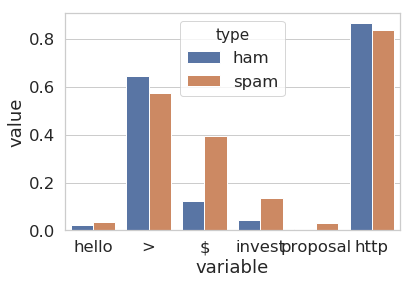

In [144]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ['hello', '>', '$', 'invest', 'proposal', 'http']

words_in_texts(words, train[train['spam'] == 1])
emails = train['email']
total = len(train)
word_count = words_in_texts(words, emails)
word_frame = pd.DataFrame(word_count, columns = words)
word_frame['type'] = train['spam']
melt = word_frame.melt("type")
melt.loc[melt['type'] == 0, 'type'] = 'ham'
melt.loc[melt['type'] == 1, 'type'] = 'spam'

sns.barplot(x = 'variable', y = 'value', hue= 'type', data = melt, ci = None)


'''
spam = melt[melt['type'] == 1]
spam_counts = spam[spam['value'] == 1]['variable'].value_counts()
spam_prop = spam_counts / total
spam_frame = spam_counts.to_frame()
spam_frame['prop_spam'] = spam_prop

ham = melt[melt['type'] == 0]
ham_counts = ham[ham['value'] == 1]['variable'].value_counts()
ham_prop = np.array(ham_counts / total)
spam_frame['prop_ham'] = ham_prop

spam_frame = spam_frame.drop(['variable'], axis=1)
spam_frame
'''

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

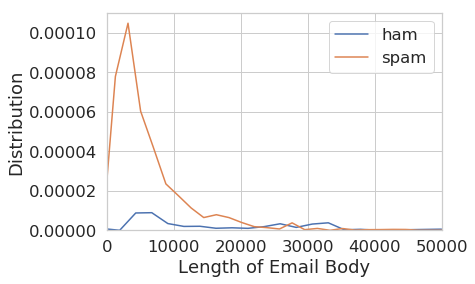

In [145]:
spam_e = train[train['spam'] == 1]['email'].apply(len)
ham_e = train[train['spam'] == 0]['email'].apply(len)
ax = sns.distplot(ham_e, label="ham", hist=False)
sns.distplot(spam_e, label="spam", hist=False)
ax.set(xlabel='Length of Email Body', ylabel='Distribution')
ax.set(xlim=(0, 50000))
ax.legend()

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [146]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [147]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [148]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [149]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [150]:
zero_predictor_fp = 0
zero_predictor_fn = len(train[train['spam'] == 1])

In [151]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do NOT use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [152]:
zero_predictor_acc = len(train[train['spam'] == 0]) / len(train)
print(zero_predictor_acc)
zero_predictor_recall = 0

0.7447091707706642


In [153]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

FP is 0 because there are no positives. FN is the number of True Positives, or the number of actual spam emails. Accuracy is the number of TP + TF / all emails, or just the number of true falses / all emails. The recall is TP / TP + FN, but TP is 0 so recall is also 0

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do NOT use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [154]:
total = len(X_train)

predict = model.predict(X_train)
TP = sum(predict & Y_train)

FP = sum(predict & ~Y_train)

FN = sum(~predict & Y_train)

TN = total - TP - FP - FN
print(total, TP, FP, FN, TN)


logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_far = FP / (FP + TN)

print(logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far)

7513 219 122 1699 5473
0.6422287390029325 0.11418143899895725 0.021805183199285077


In [155]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

More False Negatives

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

1. This is more accurate than the 74.4% accuracy of the 0 only predictor.
2. These words are common in both spam and ham emails, so there is some error.
3. I prefer the logistic regression model because of higher accuracy, but the ~2% false alarm rate is troublesome. I think the words we chose should be improved.

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 10).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

ou may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [156]:
#print("Length of Email")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.len().mean())

In [157]:
#print("% Uppercase")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.split().stack().str.isupper().sum().mean())

In [158]:
#print("Number of Words in Email")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.split().apply(len).mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.split().apply(len).mean())

In [159]:
#print("Number of Words in Subject")
#print("Not Spam:", train[train["spam"] == 0]["subject"].str.split().apply(len).mean())
#print("Spam:", train[train["spam"] == 1]["subject"].str.split().apply(len).mean())

In [160]:
#print("Number of <")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('<').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('<').str.len().mean())

In [161]:
#print("Length of Subject")
#print("Not Spam:", train[train["spam"] == 0]["subject"].str.len().mean())
#print("Spam:", train[train["spam"] == 1]["subject"].str.len().mean())

In [162]:
#print("Number of !")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('!').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('!').str.len().mean())

In [163]:
#print("Number of $")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('$').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('$').str.len().mean())

In [164]:
#print("Number of %")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('%').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('%').str.len().mean())

In [165]:
#print("Number of &")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('&').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('&').str.len().mean())

In [166]:
#print("Number of ;")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall(';').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall(';').str.len().mean())

In [167]:
#print("Number of >")
#print("Not Spam:", train[train["spam"] == 0]["email"].str.findall('>').str.len().mean())
#print("Spam:", train[train["spam"] == 1]["email"].str.findall('>').str.len().mean())

In [168]:
#!pip install WordCloud
#from os import path
#from wordcloud import WordCloud

In [169]:
#spam = train[train['spam'] == 1]['email']
#wordcloud = WordCloud(max_font_size=40).generate(' '.join(spam))
#plt.figure()
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

In [170]:
'''
spam_s = train[train['spam'] == 1]['subject']
wordcloud = WordCloud(max_font_size=40).generate(' '.join(spam_s))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
'''

'\nspam_s = train[train[\'spam\'] == 1][\'subject\']\nwordcloud = WordCloud(max_font_size=40).generate(\' \'.join(spam_s))\nplt.figure()\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()\n'

In [171]:
'''
ham = train[train['spam'] == 0]['email']
wordcloud = WordCloud(max_font_size=40).generate(' '.join(ham))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
'''

'\nham = train[train[\'spam\'] == 0][\'email\']\nwordcloud = WordCloud(max_font_size=40).generate(\' \'.join(ham))\nplt.figure()\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()\n'

In [172]:
'''
ham_s = train[train['spam'] == 0]['subject']
wordcloud = WordCloud(max_font_size=40).generate(' '.join(ham_s))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
'''

'\nham_s = train[train[\'spam\'] == 0][\'subject\']\nwordcloud = WordCloud(max_font_size=40).generate(\' \'.join(ham_s))\nplt.figure()\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()\n'

In [173]:
def add_additional_columns(data):
    data["length email"] = data["email"].str.len()
    data["words in email"] = data["email"].str.split().apply(len)
    data["Num chars"] = data["email"].str.findall('[a-zA-Z]').str.len()
    data["Num !"] = data["email"].str.findall('!').str.len()
    data["Num ;"] = data["email"].str.findall(';').str.len()
    data["Num %"] = data["email"].str.findall('%').str.len()
    data["Num $"] = data["email"].str.findall('$').str.len()
    data["Subject Re"] = data["subject"].str.findall("Re:").str.len().fillna(0)
    data["Subject Fwd"] = data["subject"].str.findall("Fwd").str.len().fillna(0)
    data["Length of Subject"] = len(data['subject'])
    data["Online"] = data["email"].str.findall("online").str.len()
    data["Num <"] = data["email"].str.findall('<').str.len()
    data["Num >"] = data["email"].str.findall('>').str.len()
    data["Buy"] = data["email"].str.findall("buy").str.len()
    data["http"] = data["email"].str.findall('http').str.len()
    data["https"] = data["email"].str.findall('https').str.len()
    data["html"] = data["email"].str.findall('html').str.len()
    data["body"] = data["email"].str.findall('body').str.len()
    data["Num /"] = data["email"].str.findall('/').str.len()
    data["br"] = data["email"].str.findall('br').str.len()
    data["img"] = data["email"].str.findall("img").str.len()
    data["src"] = data["email"].str.findall('src').str.len()
    data["earn"] = data["email"].str.findall("earn").str.len()
    data["tr"] = data["email"].str.findall('tr').str.len()
    data["td"] = data["email"].str.findall('td').str.len()
    data["size"] = data["email"].str.findall('size').str.len()
    data["free"] = data["email"].str.findall('free').str.len()
    data["pills"] = data["email"].str.findall('pills').str.len()
    data["computer"] = data["email"].str.findall('computer').str.len()
    data["width"] = data["email"].str.findall("width").str.len()
    data["height"] = data["email"].str.findall('height').str.len()
    return data

In [174]:
my_model = LogisticRegression(C=100)

train_new = add_additional_columns(train)
val_new = add_additional_columns(val)

val_test = val['spam']
val_newer = val_new.drop(['spam', 'subject', 'email'], axis=1)

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [175]:
my_y_train = train_new['spam']
my_x_train = train_new.drop(["spam", "subject", "email"], axis=1)
my_model.fit(my_x_train, my_y_train)
my_train_accuracy = my_model.score(my_x_train, my_y_train)
valid_accuracy = my_model.score(val_newer, val_test)
print("Train", my_train_accuracy)
print("Valid", valid_accuracy)

Train 0.8883269000399308
Valid 0.8850299401197604


### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

1. I calculated the average amounts of each feature for spam and ham emails. If there was a significant difference this would be a good candidate to include. I also used wordclouds to find which words were most common in the emails and picked ones that were unique. I also used google to find common spam words. At the end, I was left with a lot of features, and used the regularization paramater to prevent overfitting. 
2. The wordclouds didnt work well because many of the common words were common in both ham and spam. Testing features manually to see the difference in the two was sort of effective, but not as effective as graphing and finding linearly separable features. L1 regularization did not work and reduced my accuracy, which surprised me because I thought it would prevent overfitting. 
3. I was surprised to find that the combination of features mattered a lot. I thought deleting or adding a feature wouldn't affect the accuracy of the model, but it turned out that a single feature could affect the accuracy by 2-3% depending on the weight assigned to it.

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

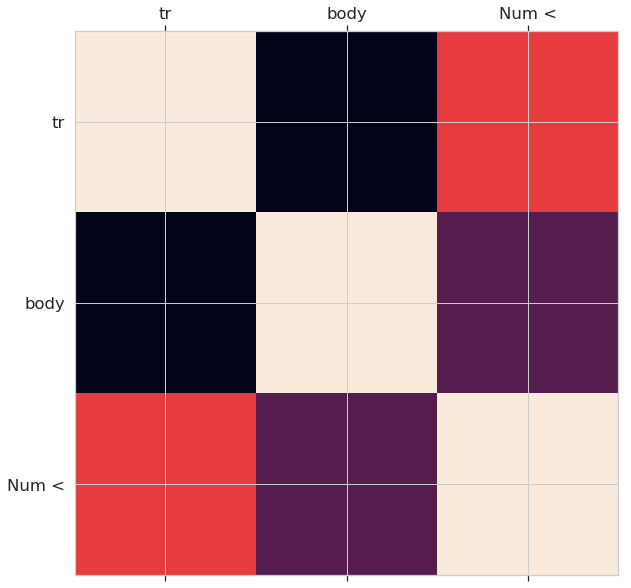

In [176]:
# Write your description (2-3 sentences) as a comment here:
# This is a correlation matrix for 3 of the features that I looked at for the regression model. 
# The graph shows that these 3 features have a strong correlation (indicated by the color)
# This data indicated that if 2 of the 3 features are in an email, there is a higher probabilty the email is spam.

# Write the code to generate your visualization here:


def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

new = train_new[['tr', 'body', 'Num <']].copy()
plot_corr(new)



### Question 9: Precision-Recall Curve

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier (the one you use to make predictions for Kaggle).

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

In [177]:
test_new = add_additional_columns(test)
test_x = test_new.drop(['subject', 'email'], axis=1)

Text(0, 0.5, 'Precision')

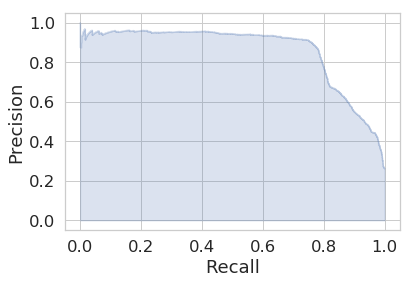

In [178]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

y_score = my_model.predict_proba(my_x_train)
new = [x[1] for x in y_score]

precision, recall, threshold = precision_recall_curve(my_y_train, new)


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')


# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/1b01c36920b74f0e8502a69760775a1d

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [179]:
test_predictions = my_model.predict(test_x)

In [180]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [181]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-04-16T12:08:11.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [182]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
Saved proj2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 

ERROR  | auth.py:91 | {'error': 'invalid_grant'}


Saved 'proj2.ipynb'.
Performing authentication
Please enter your bCourses email.
bCourses email: gottiparthy.ani@berkeley.edu

Copy the following URL and open it in a web browser. To copy,
highlight the URL, right-click, and select "Copy".

https://okpy.org/client/login/

After logging in, copy the code from the web page, paste it below,
and press Enter. To paste, right-click and select "Paste".

Paste your code here: CwiODL32iFdCcHZqG2L1Jk9hjy5Yw4
Successfully logged in as gottiparthy.ani@berkeley.edu
Submit... 100% complete
Submission successful for user: gottiparthy.ani@berkeley.edu
URL: https://okpy.org/cal/data100/sp19/proj2/submissions/p8nwlp

